<a href="https://colab.research.google.com/github/anelglvz/Matematicas_Ciencia_Datos/blob/main/%C3%81lgebra/Image_Denoising/Image_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contexto

El ruido en las imágenes está constituido por variaciones aleatorias en el brillo o los colores en una imagen. El ruido se crea en la imagen por el modo en que es capturada (variación de la luz, calidad de la cámara, sensores de imagen), hasta ruido introducido por el modo en que es almacenada la imagen.

# Funciones a utilizar (para comparativos)

- PSNR(Peak Signal-to-Noise Ratio)

PSNR es la razón entre el valor máximo de una señal y el poder de ruido que afecta la fidelidad de la representación.

PSNR (en decibeles) se define como:

<center> <img src='imgs\psnr.svg'> </center>

Donde MSE es el error cuadratico medio entre una imagen inicial monocromática y una aproximación que tiene ruido.

- SSIM (Structural Similarity)

Este método está mas interesado en utilizar la idea de que los pixeles son fuertemente interdependientes (especialmente de sus vecinos cercanos). Utiliza máscaras de iluminación y de contraste.

<center> <img src='imgs\SSIM.svg'> </center>

donde 1 indica similitud perfecta, 0 indica que no hay similitud y -1 indica anticorrelación perfecta.

Obtenido de https://github.com/Gaurav-Pande/Image-Denoising

In [ ]:
!pip3 install scikit-image

In [1]:
import skimage

In [2]:
# Revisamos la versión de skimage
skimage.__version__

'0.24.0'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import skimage as ski
from skimage.metrics import structural_similarity as ssim      # Antes de la version 0.18 de skimage, estaban en submodulo measure
from skimage.metrics import peak_signal_noise_ratio as psnr    # Antes de la version 0.18 de skimage, estaban en submodulo measure

In [4]:
# Imagen paa pruebas
img_filename = './cameraman.tif'
img_prueba = plt.imread(img_filename).astype(dtype=float)

In [5]:
img_prueba

array([[156., 159., 158., ..., 151., 152., 152.],
       [160., 154., 157., ..., 154., 155., 153.],
       [156., 159., 158., ..., 151., 152., 152.],
       ...,
       [114., 132., 123., ..., 135., 137., 114.],
       [121., 126., 130., ..., 133., 130., 113.],
       [121., 126., 130., ..., 133., 130., 113.]])

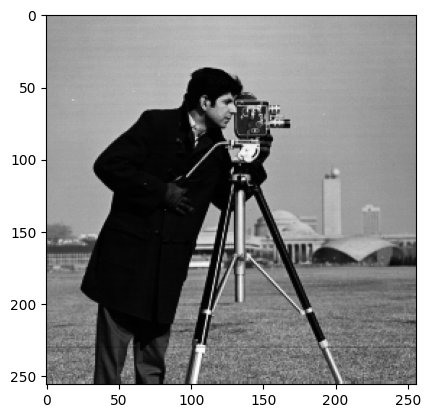

In [6]:
plt.imshow(img_prueba, cmap='gray')
plt.show()

### Explicación de la función getpca(X)
La función getpca recibe un solo argumento 
𝑋, 
que es una matriz de 
𝑀
×
𝑁
donde 
𝑀
 es el número de características (variables) y 
𝑁
 es el número de muestras (observaciones).

**Paso 1: Calculamos la media**
Se calcula la media de 
𝑋
 a lo largo del eje 1 (media por característica), lo que da como resultado un vector columna 
𝑚
𝑥
 de forma 
𝑀
×
1
.

**Paso 2: Centramos los datos** Se resta el vector de media 
𝑚
𝑥
 de cada columna de 
𝑋
, centrando así los datos en torno al origen (media cero).

**Paso 3: Calculamos la matriz de covarianza y obtenemos los valores propios** Se calcula la matriz de covarianza CovX como el producto punto de 
𝑋 
con su transpuesta, normalizada por 
𝑁
−
1
 (corrección de Bessel).

**Paso 4: Ordenamos los valores y vectores propios** Lo hacemos de forma ascendente

**Paso 5: Proyectamos en el nuevo espacio** Los datos centrados 
𝑋
 se proyectan en la nueva base definida por los vectores propios 
𝑃
 lo que resulta en 
𝑌
, que contiene los componentes principales.

In [7]:
def getpca(X):
    # %X: MxN matrix
    # %Y: Y=P*X
    # %P: matriz de transformación
    # %V: los eigenvalores ordenados en la salida

    [M, N] = X.shape

    mx = (np.mean(X, axis=1)).reshape((M, 1))

    X = X - mx

    CovX = (X @ X.T) / (N-1)
    [V, P]= np.linalg.eig(CovX) # V son los eigenvalores, P, los eigenvectores

    V_minus = -1 * V
    ind = np.argsort(V_minus, axis=0)

    V = V[ind]
    P = P[:, ind]

    P = P.T
    Y = np.matmul(P, X)
    # Y = P @ X

    # Pt @ Y = X
    # Pt = U
    # Y = D @ Vt
    # U @ D @ Vt = X
    # Y son los componentes principales
    # P son los loadings

    return [Y, P, V, mx]

In [8]:
np.set_printoptions(suppress=True)
getpca(img_prueba)[2]

array([388285.54040314, 118509.67349474,  38871.51697632,  35096.35871114,
        23002.87407307,  20872.70588632,  14032.75383728,  12079.67014452,
         9835.0556509 ,   9414.24156558,   9041.44847998,   8531.46283866,
         8103.26020917,   6619.94332649,   5779.51969304,   5352.2338874 ,
         4930.62828759,   4034.61222204,   3845.25099736,   3578.55477539,
         3227.53550401,   2616.01335672,   2501.91741834,   2460.00557362,
         2264.46314422,   2157.15380446,   1922.75337982,   1801.94264422,
         1764.08349705,   1629.01834553,   1522.43584152,   1500.81085376,
         1355.24536552,   1289.28847294,   1194.54314056,   1151.56910108,
         1110.51467214,   1083.73927634,   1020.67302764,    974.54023741,
          905.86921401,    866.17004808,    842.29603741,    803.00279715,
          768.54347668,    715.6881513 ,    703.3196487 ,    688.77422321,
          653.88730379,    611.26873386,    569.80628035,    558.27803392,
          537.4142182 ,  

In [9]:
# Función utilizada para 'inflar' mis imágenes en blanco y negro
def blow_gray(B):
    [n, m] = B.shape
    n = 2 * n
    m = 2 * m
    A = np.zeros((n,m))

    A[0:n:2, 0:m:2] = B
    A[0:n:2, 1:m:2] = B
    A[1:n:2, 0:m:2] = B
    A[1:n:2, 1:m:2] = B

    return A

La función **LPG_new** realiza un agrupamiento local de píxeles. Su objetivo es encontrar un conjunto de vectores de muestras (o píxeles) que son más similares al vector central en un bloque de entrenamiento definido alrededor de una posición dada.

**Paso 1: Obtener dimensiones** Se obtienen las dimensiones de la matriz auxiliar 
𝐼
 y se almacena el número de columnas de 
𝑋
 en f2, que representa la cantidad de características (o dimensiones) de cada vector de muestra.

**Paso 2: Definir el bloque variable** 
- rmin: Borde superior (fila mínima)
- rmax: Borde inferior (fila máxima)
- cmin: Borde izquierdo (columna mínima)
- cmax: Borde derecho (columna máxima)

**Paso 3: Obtenemos los índices de los Vectores en el Bloque de Entrenamiento** Se extraen los índices de los vectores en el bloque de entrenamiento usando la matriz auxiliar 
𝐼
 en los rangos definidos. Luego, se aplana la matriz de índices para tener una lista unidimensional de índices.

**Paso 4: Obtenemos vectores del training block y del centro del bloque**

**Paso 5: Calculamos las distancias entre vectores** Se calcula la distancia al cuadrado entre el primer elemento de cada vector en 
𝐵
 y el primer elemento del vector central 
𝑣
. Esto se hace para cada dimensión del vector, y se inicializa la matriz de distancias.


**Paso 6: Calculamos las distancias para todas las dimensiones**

**Paso 7: Promediamos las distancias, ordenamos y regresamos los vectores con menor distancia**

In [10]:
def LPG_new(X, row, col, off, nv, S, I):
    """Local Pixel Grouping

    X: Matriz de MxN que tiene los "sample vectors" de x_v como vectores fila
    row: fila del centro del block variable
    col: columna del centro del block variable
    off: Nos da la posicion del vector en el centro del training block
    nv: Número mínimo de vectores a regresar de V.
    S: Mitad del tamaño del training block
    I: Matriz auxiliar para recuperar los vectores correpondientes a cada block variable
    """
    [N, M] = I.shape
    f2 = X.shape[1]

    # borde superior del variable block
    rmin = max(row - S, 0)
    # borde inferior
    rmax = min(row + S + 1, N)
    # borde izquierdo
    cmin = max(col - S, 0)
    # Borde derecho
    cmax = min(col + S + 1, M)

    # print("rmin, rmax, cmin, cmax: ", rmin, rmax, cmin, cmax)
    # Obtenemos los índices de los vectores en el training block
    idx = I[rmin: rmax, cmin: cmax]
    idx = (idx.T).flatten()

    # Obtiene todas las vectores dentro del training block
    B = X[idx,:]
    # Vector del centro del bloque
    v = X[off,:]

    # calculamos la distancia entrada a entrada de cada variable block respecto a la del vector del centro
    dis = ((B[:, 0] - v[0])**2)
    dis = dis.reshape((dis.shape[0], 1))

    for k in range(1, f2):
        # print("k: ", k)
        # k = int(k/S)
        dis_partial = ((B[:, k] - v[k])**2)
        dis_partial = dis_partial.reshape((dis_partial.shape[0], 1))
        dis = dis + dis_partial

    dis = dis/f2
    # Se ordenan de menor a mayor
    ind = np.argsort(dis, axis=0)
    # Se obtiene los nv vectores con menor distancia
    indc = idx[ind[0:nv]]

    return indc

In [11]:
def dim_reduction(X):
    # Obtenemos el número de filas
    n = X.shape[0]
    # Calcula el número de componentes principales a usar (40% de n)
    n = math.floor(n * 0.4)
    # Llamamos getpca
    [coe, P, V, mX] = getpca(X)
    # Proyectamos los datos originales X en el espacio reducidp. 
    Y = P[0 : n, :] @ X
    return Y

El siguiente código implementa un algoritmo de eliminación de ruido en imágenes utilizando un **método de agrupamiento de píxeles locales (LPG)** y un **Análisis de Componentes Principales (PCA).**

<img src='./imgs/pipeline.png'/>

**Limitaciones:**
- Se pide como entrada un nivel estimado de ruido
- La computación es bastante intensiva

**Entradas:**
- noise_img: Imagen con ruido.
- orig_img: Imagen original (sin ruido).
- std: Desviación estándar del ruido.
- profile: Modo de procesamiento ('fast' o 'normal').
- K: Parámetro para recortar los bordes de la imagen.

**Algoritmo**

**Inicialización**

Determina el tamaño de los bloques de píxeles que se utilizarán para el procesamiento basado en el perfil y las dimensiones de las imágenes.

**Creación de Bloque**

Se generan bloques de píxeles de la imagen ruidosa para su posterior análisis. Estos bloques son arreglos de píxeles que se consideran "vecinos" y se utilizan para estimar el valor del píxel central.

**Reducción de Dimensionalidad**

Dependiendo del perfil, se puede reducir la dimensionalidad de los bloques utilizando PCA para facilitar el procesamiento.

**Proceso de Denoising**

Para cada posible píxel central, se identifican los bloques más cercanos utilizando la función LPG_new, que agrupa píxeles similares.
Se aplica PCA a estos bloques para encontrar componentes principales y se ajustan los valores de los píxeles utilizando la varianza y los pesos calculados.
Se reconstruye la imagen filtrada (dI) a partir de los bloques procesados.

**Normalización**

La imagen resultante se normaliza para evitar valores fuera del rango de intensidad aceptable.

**Refinamiento**

Se repite el proceso de eliminación de ruido para refinar aún más la imagen.

In [22]:
# LPG de local pixel grouping
def LPGPCA_denoising(noise_img, orig_img, std, profile, K):
    s = 2
    if profile == 'fast':
        s = 2
    elif profile == 'normal':
        s = 1

    [n, m] = orig_img.shape
    [h, w] = noise_img.shape

    #-----------------------------------------------------------------
    # First stage: denoising
    #-----------------------------------------------------------------

    v2 = std**2
    # training block(2k + 1) * (2k + 1)
    S = 20
    # variable block(2t + 1) * (2t + 1)
    t = 3
    # nblk representa el número mínimo de vectores (o bloques) similares que se desean recuperar para cada píxel central
    nblk = 250
    b = 2 * t + 1
    b2 = b * b

    k = 0
    # Número de filas que tienen pixeles a eliminar ruido
    N = h - b + 1
    # Número de columnas que tienen pixeles a eliminar ruido
    M = w - b + 1
    # Cantidad de pixeles que pueden ser centro de "variable block"
    L = N * M
    r = np.arange(0, N, s)
    # ¿La última entrada de r es menor a N-1?
    if r[-1] < (N - 1):
        r = np.hstack((r, np.arange(r[-1], N, 1)))

    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c, np.arange(c[-1], M, 1)))

    # Matriz para alojar todos los posibles bloques
    X = np.zeros((b*b, L))

    # i recorre la matriz de arriba a abajo
    # j de izquierda a derecha
    # Cuando i,j = 0, se llena la primera entrada de todos los posibles bloques (variable block) y avanza para llenar las demás
    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1)]
            blk = (blk.T).flatten()
            X[k, :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    # Matriz auxiliar para recuperar los vectores correspondientes a cada variable block
    I = np.arange(L)
    I = (I.reshape((M, N))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2, L))

    # Para cada fila en la que puede haber un pixel a quitar ruido (centro del variable block )
    for i in range(N1):
        # Para cada columna en la que puede haber un pixel a quitar ruido (centro del variable block)
        for j in range(M1):
            # para profile = 'normal', se selecciona el centro de cada variable block,
            # de izquierda a derecha, de arriba a abajo
            row = r[i]
            col = c[j]
            # El índice del vector en X, correpondiente al centro  del variable block
            off = (col * N) + row
            off1 = (j * N1) + i

            # Se obtienen los índices de los nblk-th vectores más cercanos
            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()
            # PCA sobre los vectores más cercanos al 'pixel to be denoised'
            [coe, P, V, mX] = getpca(X[:, indc])
            # Varianza de Y = coe
            py = np.mean(coe**2, axis=1)
            # Se transforma a vector columna
            py = py.reshape((py.shape[0], 1))
            px = np.maximum(np.zeros(py.shape), py - v2)
            wei = px/py
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]


    # Fin: Output the processed image
    dI = np.zeros((h, w))
    im_wei = np.zeros((h, w))
    k = 0
    for i in range(b):
        for j in range(b):
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv] = dI[rv, cv] + (Y[k, :].T).reshape((N1, M1))
            im_wei[rv, cv] = im_wei[rv, cv] + 1
            k = k + 1

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))
    print("imwei.max: ", np.max(im_wei))
    print("imwei.min: ", np.min(im_wei))

    eps = 1e-23
    dI = dI/(im_wei + eps)

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))

    psnr_1 = 0
    ssim_1 = 0

    plt.imshow(dI, cmap='gray')
    plt.title('primer paso procesamiento')
    plt.show()

    row, col = orig_img.shape
    orig_img_crop = orig_img.astype(dtype=int)
    dI_crop = dI.astype(dtype=int)
    psnr_1 = psnr(orig_img_crop, dI_crop)
    ssim_1 = ssim(orig_img_crop, dI_crop)

    dif = dI[(K) : (n - K), (K) : (m - K)] - noise_img[(K) : (n - K), (K) : (m - K)]
    print ("mean diff: ", np.mean(dif**2))
    vd = std**2 - np.mean(dif**2)
    v1 = math.sqrt(abs(vd))
    print ("v1: ", v1)

    
    #-----------------------------------------------------------------
    # The second stage: refinement
    #-----------------------------------------------------------------

    psnr_2 = 0
    ssim_2 = 0

    noise_img = dI
    v = v1 * 0.36
    v2 = v**2

    k = 0
    N = h - b + 1
    M = w - b + 1
    L = N * M
    r = np.arange(0, N, s)
    if r[-1] < (N - 1):
        r = np.hstack((r, np.arange(r[-1], N, 1)))

    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c, np.arange(c[-1], M, 1)))

    X = np.zeros((b*b, L))

    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1)]
            blk = (blk.T).flatten()
            X[k, :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    I = np.arange(L)
    I = (I.reshape((M, N))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2, L))

    for i in range(N1):
        for j in range(M1):
            row = r[i]
            col = c[j]
            off = (col * N) + row
            off1 = (j * N1) + i

            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()
            [coe, P, V, mX] = getpca(X[:, indc])
            py = np.mean(coe**2, axis=1)
            py = py.reshape((py.shape[0], 1))
            px = np.maximum(np.zeros(py.shape), py - v2)
            wei = px/py
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]


    # Output the processed image
    dI = np.zeros((h, w))
    im_wei = np.zeros((h, w))
    k = 0

    for i in range(b):
        for j in range(b):
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv] = dI[rv, cv] + (Y[k, :].T).reshape((N1, M1))
            im_wei[rv, cv] = im_wei[rv, cv] + 1
            k = k + 1

    eps = 1e-23
    dI = dI/(im_wei + eps)

    row, col = orig_img.shape

    print("dI2.max: ", np.max(dI))
    print("dI2.min: ", np.min(dI))

    orig_img_crop = orig_img.astype(dtype=int)
    dI_crop = dI.astype(dtype=int)

    # Comparaciones
    psnr_2 = psnr(orig_img_crop, dI_crop)
    ssim_2 = ssim(orig_img_crop, dI_crop)

    plt.imshow(dI, cmap='gray')
    plt.title('Output de imagen procesada')
    plt.show()

    d_im = dI[K:n-K, K:m-K]

    return [d_im, psnr_1, ssim_1, psnr_2, ssim_2]

<img src='./imgs/PCA a la inversa.png'>

orig_img.shape:  (256, 256)
orig_img.max:  253.0
orig_img.min:  7.0


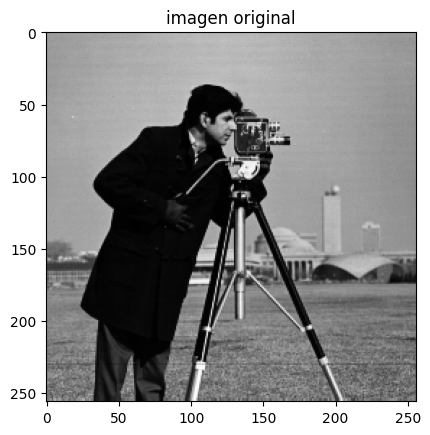

noise_img.shape:  (256, 256)
noise_img.max:  301.43925395864215
noise_img.min:  -71.84859949192926


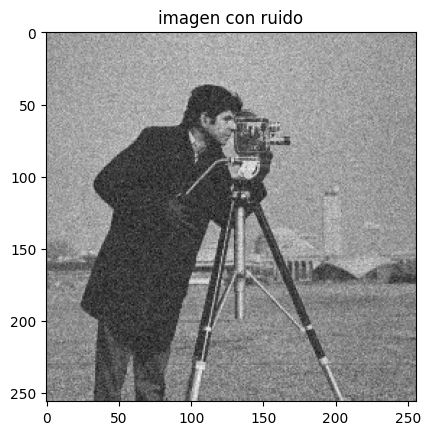

dI.max:  13261.221033512073
dI.min:  -904.0621773779682
imwei.max:  49.0
imwei.min:  1.0
dI.max:  270.63716394922596
dI.min:  -18.450248517917718


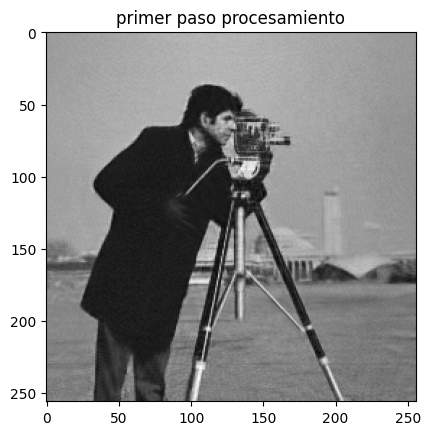

mean diff:  282.3525070249642
v1:  10.846542904309915


/var/folders/_2/ssn9p4gn1zq96vptrk6db0940000gn/T/ipykernel_7463/2200386134.py:131: UserWarning: Setting data_range based on im1.dtype. data_range = 18446744073709551616. Please specify data_range explicitly to avoid mistakes.
  ssim_1 = ssim(orig_img_crop, dI_crop)


dI2.max:  270.16426056230614
dI2.min:  -15.612025583725053


/var/folders/_2/ssn9p4gn1zq96vptrk6db0940000gn/T/ipykernel_7463/2200386134.py:233: UserWarning: Setting data_range based on im1.dtype. data_range = 18446744073709551616. Please specify data_range explicitly to avoid mistakes.
  ssim_2 = ssim(orig_img_crop, dI_crop)


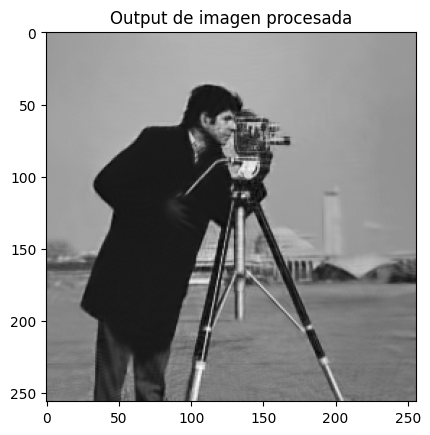

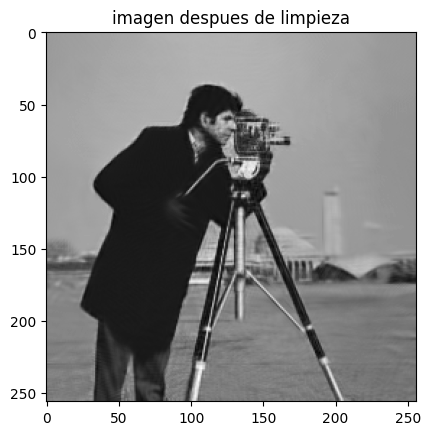

psnr1:  360.6470439203153
ssim1:  1.0
psnr2:  360.853881220485
ssim2:  1.0


In [23]:
profile = 'normal'
std = 20
img_filename = './cameraman.tif'
orig_img = plt.imread(img_filename).astype(dtype=float)
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img, cmap='gray')
plt.title('imagen original')
plt.show()

seed = 0
random.seed(seed)

noise = np.random.normal(size=(orig_img.shape))
noise = noise/np.sqrt(np.mean(noise**2))
noise_img = orig_img + (std * noise)
print("noise_img.shape: ", noise_img.shape)
print("noise_img.max: ", np.max(noise_img))
print("noise_img.min: ", np.min(noise_img))
plt.imshow(noise_img, cmap='gray')
plt.title('imagen con ruido')
plt.show()

#El ancho de los límites excluidos
bound_exclude_width = 0

[denoise_img, psnr1, ssim1, psnr2, ssim2] =\
    LPGPCA_denoising(noise_img, orig_img, std, profile, bound_exclude_width)

plt.imshow(denoise_img, cmap='gray')
plt.title('imagen despues de limpieza')
plt.show()

print("psnr1: ", psnr1)
print("ssim1: ", ssim1)
print("psnr2: ", psnr2)
print("ssim2: ", ssim2)


- **dI.max/min:** Indican los valores extremos de intensidad acumulados y normalizados en la imagen denoised.
- **imwei.max/min:** Representan la cantidad de contribuciones de bloques a cada píxel, asegurando que cada píxel haya sido procesado al menos una vez.
- **mean diff:** Error cuadrático medio (Mean Squared Error, MSE) entre la imagen denoised (dI) y la imagen ruidosa original (noise_img).
- **v1:** Estimación refinada de la desviación estándar del ruido residual.

orig_img.shape:  (256, 256)
orig_img.max:  253.0
orig_img.min:  7.0


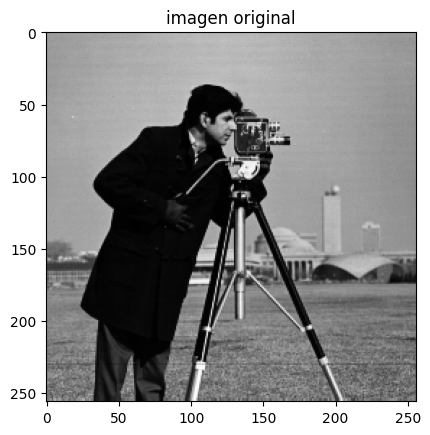

noise_img.shape:  (256, 256)
noise_img.max:  302.9408428023796
noise_img.min:  -57.772028761142906


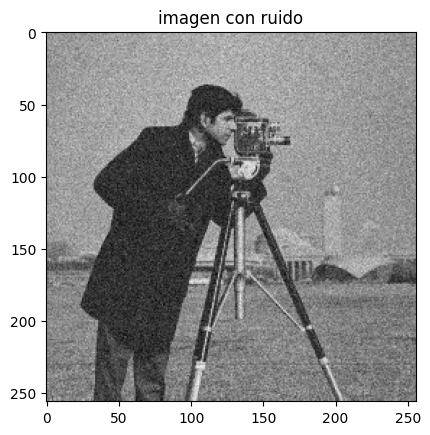

dI.max:  4182.6082589231055
dI.min:  -376.2631790422623
imwei.max:  16.0
imwei.min:  1.0
dI.max:  270.9958063286171
dI.min:  -26.286874900109158


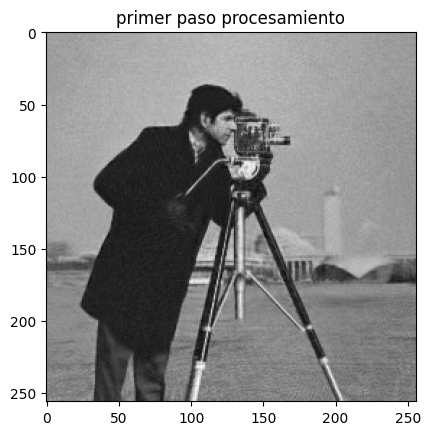

mean diff:  247.20555925695697
v1:  12.361004843581409


/var/folders/_2/ssn9p4gn1zq96vptrk6db0940000gn/T/ipykernel_7463/1380445116.py:137: UserWarning: Setting data_range based on im1.dtype. data_range = 18446744073709551616. Please specify data_range explicitly to avoid mistakes.
  ssim_1 = ssim(orig_img_crop, dI_crop)


dI2.max:  269.85643565278855
dI2.min:  -25.390713769629134


/var/folders/_2/ssn9p4gn1zq96vptrk6db0940000gn/T/ipykernel_7463/1380445116.py:239: UserWarning: Setting data_range based on im1.dtype. data_range = 18446744073709551616. Please specify data_range explicitly to avoid mistakes.
  ssim_2 = ssim(orig_img_crop, dI_crop)


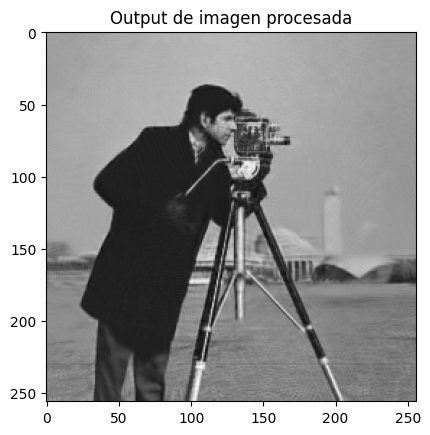

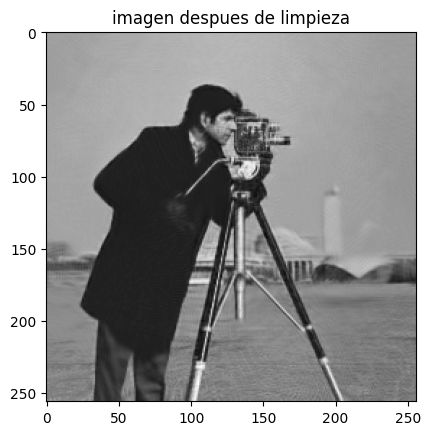

psnr1:  360.4427888593461
ssim1:  1.0
psnr2:  361.0567400734474
ssim2:  1.0


In [14]:
profile = 'fast'
std = 20
img_filename = './cameraman.tif'
orig_img = plt.imread(img_filename).astype(dtype=float)
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img, cmap='gray')
plt.title('imagen original')
plt.show()

seed = 0
random.seed(seed)

noise = np.random.normal(size=(orig_img.shape))
noise = noise/np.sqrt(np.mean(noise**2))
noise_img = orig_img + (std * noise)
print("noise_img.shape: ", noise_img.shape)
print("noise_img.max: ", np.max(noise_img))
print("noise_img.min: ", np.min(noise_img))
plt.imshow(noise_img, cmap='gray')
plt.title('imagen con ruido')
plt.show()

#El ancho de los límites excluidos (lo dejamos en 0)
bound_exclude_width = 0

[denoise_img, psnr1, ssim1, psnr2, ssim2] =\
    LPGPCA_denoising(noise_img, orig_img, std, profile, bound_exclude_width);

plt.imshow(denoise_img, cmap='gray')
plt.title('imagen despues de limpieza')
plt.show()

print("psnr1: ", psnr1)
print("ssim1: ", ssim1)
print("psnr2: ", psnr2)
print("ssim2: ", ssim2)

# Opcional: Caso a Color

In [23]:
def blow_color(B):
    [n, m, ch] = B.shape
    n = 2 * n
    m = 2 * m
    A = np.zeros((n,m,ch))

    A[0:n:2, 0:m:2, :] = B
    A[0:n:2, 1:m:2, :] = B
    A[1:n:2, 0:m:2, :] = B
    A[1:n:2, 1:m:2, :] = B

    return A

In [24]:
import PIL
import urllib

orig_img.shape:  (481, 321, 3)
orig_img.max:  255
orig_img.min:  0


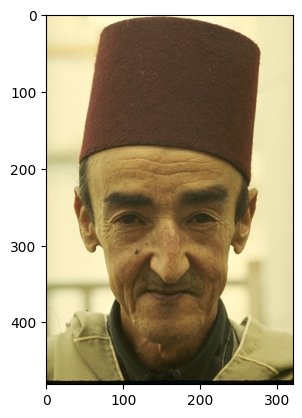

In [32]:
img_filename = './0038.png' #'0038.png'
orig_img = np.array(PIL.Image.open(img_filename))
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img)
plt.show()

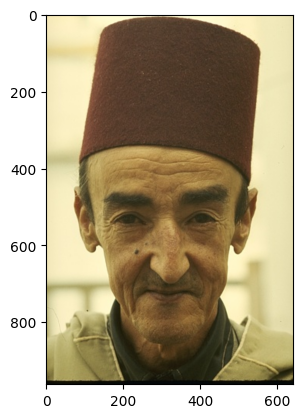

In [33]:
plt.imshow(blow_color(orig_img).astype(dtype=int))
plt.show()

In [34]:
orig_img.shape , blow_color(orig_img).shape

((481, 321, 3), (962, 642, 3))

In [35]:
from PIL import Image

In [37]:
def LPGPCA_color_denoising(noise_img, orig_img, std, profile):
    s = 4
    if profile == 'fast':
        s = 4
    elif profile == 'normal':
        s = 3

    [n, m, ch] = orig_img.shape
    [h, w, ch] = noise_img.shape

    ##############First stage denoising###############

    v2 = std**2
    # training block(2k + 1) * (2k + 1)
    S = 20
    # variable block(2t + 1) * (2t + 1)
    t = 3
    nblk = 250
    b = 2 * t + 1
    b2 = b * b

    k = 0
    N = h - b + 1
    M = w - b + 1
    L = N * M
    r = np.arange(0, N, s)
    if r[-1] < (N - 1):
        r = np.hstack((r, np.arange(r[-1], N, 1)))

    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c, np.arange(c[-1], M, 1)))

    X = np.zeros((b*b*ch, L))

    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 0]
            blk = (blk.T).flatten()
            X[k, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 1]
            blk = (blk.T).flatten()
            X[k + b2, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 2]
            blk = (blk.T).flatten()
            X[k + (2 * b2), :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    I = np.arange(L)
    I = (I.reshape((M, N))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2*ch, L))

    for i in range(N1):
        for j in range(M1):
            row = r[i]
            col = c[j]
            off = (col * N) + row
            off1 = (j * N1) + i

            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()
            [coe, P, V, mX] = getpca(X[:, indc])
            py = np.mean(coe**2, axis=1)
            py = py.reshape((py.shape[0], 1))
            px = np.maximum(np.zeros(py.shape), py - v2)
            wei = px/py
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]


    # Output the processed image
    dI = np.zeros((h, w, ch))
    im_wei = np.zeros((h, w, ch))
    k = 0
    for i in range(b):
        for j in range(b):
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv, 0] = dI[rv, cv, 0] + (Y[k, :]).reshape((M1, N1))
            im_wei[rv, cv, 0] = im_wei[rv, cv, 0] + 1
            dI[rv, cv, 1] = dI[rv, cv, 1] + (Y[(k+b2), :]).reshape((M1, N1))
            im_wei[rv, cv, 1] = im_wei[rv, cv, 1] + 1
            dI[rv, cv, 2] = dI[rv, cv, 2] + (Y[k+(2*b2), :]).reshape((M1, N1))
            im_wei[rv, cv, 2] = im_wei[rv, cv, 2] + 1
            k = k + 1

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))
    print("imwei.max: ", np.max(im_wei))
    print("imwei.min: ", np.min(im_wei))

    eps = 1e-23
    dI = dI/(im_wei + eps)

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))

    dI = np.clip(dI, a_min=0, a_max=255)

    plt.imshow(dI/np.max(dI).astype(dtype=float))
    plt.show()

    dif_1 = dI[0 : n, 0 : m, 0] - noise_img[0 : n, 0 : m, 0]
    dif_2 = dI[0 : n, 0 : m, 1] - noise_img[0 : n, 0 : m, 1]
    dif_3 = dI[0 : n, 0 : m, 2] - noise_img[0 : n, 0 : m, 2]
    vd_1 = std**2 - np.mean(dif_1**2)
    vd_2 = std**2 - np.mean(dif_2**2)
    vd_3 = std**2 - np.mean(dif_3**2)
    vd  = (vd_1 + vd_2 + vd_3)/3
    v1 = math.sqrt(abs(vd))
    print ("v1: ", v1)

    #
    #-----------------------------------------------------------------
    # The second stage: refinement
    #-----------------------------------------------------------------

    psnr_2 = 0
    ssim_2 = 0

    noise_img = dI
    v = v1 * 0.37
    v2 = v**2

    k = 0
    N = h - b + 1
    M = w - b + 1
    L = N * M
    r = np.arange(0, N, s)
    if r[-1] < (N - 1):
        r = np.hstack((r, np.arange(r[-1], N, 1)))

    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c, np.arange(c[-1], M, 1)))

    X = np.zeros((b*b*ch, L))

    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 0]
            blk = (blk.T).flatten()
            X[k, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 1]
            blk = (blk.T).flatten()
            X[k + b2, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 2]
            blk = (blk.T).flatten()
            X[k + (2 * b2), :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    I = np.arange(L)
    I = (I.reshape((M, N))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2 * ch, L))

    for i in range(N1):
        for j in range(M1):
            row = r[i]
            col = c[j]
            off = (col * N) + row
            off1 = (j * N1) + i

            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()
            [coe, P, V, mX] = getpca(X[:, indc])
            py = np.mean(coe**2, axis=1)
            py = py.reshape((py.shape[0], 1))
            # px = max(0, py - v2)
            px = np.maximum(np.zeros(py.shape), py - v2)
            wei = px/py
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]

    # Output the processed image
    dI = np.zeros((h, w, ch))
    im_wei = np.zeros((h, w, ch))
    k = 0

    for i in range(b):
        for j in range(b):
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv, 0] = dI[rv, cv, 0] + (Y[k, :]).reshape((M1, N1))
            im_wei[rv, cv, 0] = im_wei[rv, cv, 0] + 1
            dI[rv, cv, 1] = dI[rv, cv, 1] + (Y[(k+b2), :]).reshape((M1, N1))
            im_wei[rv, cv, 1] = im_wei[rv, cv, 1] + 1
            dI[rv, cv, 2] = dI[rv, cv, 2] + (Y[(k+2*b2), :]).reshape((M1, N1))
            im_wei[rv, cv, 2] = im_wei[rv, cv, 2] + 1
            k = k + 1

    eps = 1e-23
    dI = dI/(im_wei + eps)

    dI = np.clip(dI, a_min=0, a_max=255)

    print("dI2.max: ", np.max(dI))
    print("dI2.min: ", np.min(dI))

    plt.imshow(dI/np.max(dI).astype(dtype=float))
    plt.show()

    d_im = dI[:n, :m, :]

    return d_im

orig_img.shape:  (481, 321, 3)
orig_img.max:  255
orig_img.min:  0


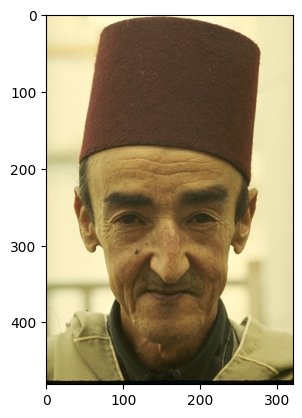

noise_img.shape:  (481, 321, 3)
noise_img.max:  255
noise_img.min:  0


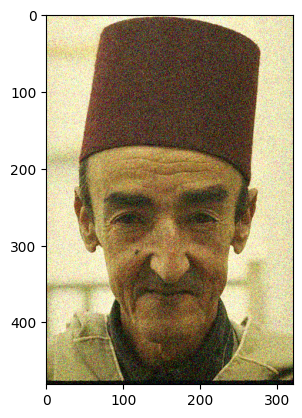

dI.max:  2853.5278999483903
dI.min:  -15.768042915997299
imwei.max:  12.0
imwei.min:  1.0
dI.max:  263.1355418415343
dI.min:  -3.9420107289993247


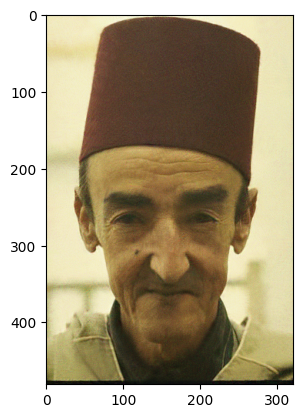

v1:  15.987870906080381
dI2.max:  255.0
dI2.min:  0.0


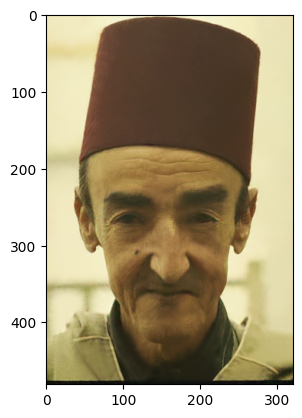

In [ ]:
profile = 'normal'
# profile = 'fast'
std = 25
img_filename = './0038.png'
orig_img = np.array(PIL.Image.open(img_filename))
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img)
plt.show()

seed = 0
random.seed(seed)

# Utilizaremos una imagen que ya tiene
img_filename2 = './0038.png'
noise_img = np.array(PIL.Image.open(img_filename2))
print("noise_img.shape: ", noise_img.shape)
print("noise_img.max: ", np.max(noise_img))
print("noise_img.min: ", np.min(noise_img))
plt.imshow(noise_img)
plt.show()

# plt.imsave('noise_'+img_filename[:-3]+'png', noise_img, cmap='gray')

#The width of the excluded boundaries, set to 20 to get the results in our paper
#bound_exclude_width = 0

#[denoise_img, psnr1, ssim1, psnr2, ssim2] =\
#    LPGPCA_color_denoising(noise_img[0:250, 0:250, :], orig_img[0:250, 0:250, :], std, profile, bound_exclude_width);



denoise_img = LPGPCA_color_denoising(noise_img, orig_img, std, profile)



# plt.imsave('denoised_'+img_filename[:-3]+'png', noise_img, cmap='gray')
# plt.imsave('denoised_'+img_filename[:-3]+'png', denoise_img, cmap='gray')


#plt.imshow(denoise_img/np.max(denoise_img).astype(dtype=float))
#plt.show()


In [ ]:
img_filename = './0038.png'
orig_img = np.array(PIL.Image.open(img_filename))
#orig_img = orig_img[:250, :250, :]
img_filename2 = './0038.png'
noise_img = np.array(PIL.Image.open(img_filename2))
#noise_img = noise_img[:250, :250, :]
denoise1_img = plt.imread('/content/denoised_first.png').astype(dtype=float)
denoise2_img = plt.imread('/content/denoised_second.png').astype(dtype=float)

denoise1_img = denoise1_img[:, :, 0:3]
denoise2_img = denoise2_img[:, :, 0:3]

# Estas imagenes se crean en el drive en el cuadro de código anterior
print("denoise1_img.shape: ", denoise1_img.shape)
print("denoise2_img.shape: ", denoise2_img.shape)
psnr_1 = psnr(orig_img/np.max(orig_img), denoise1_img)
ssim_1 = ssim(orig_img/np.max(orig_img), denoise1_img, channel_axis=2)
psnr_2 = psnr(orig_img/np.max(orig_img), denoise2_img)
ssim_2 = ssim(orig_img/np.max(orig_img), denoise2_img, channel_axis=2)

print("psnr1: ", psnr_1)
print("ssim1: ", ssim_1)
print("psnr2: ", psnr_2)
print("ssim2: ", ssim_2)

denoise1_img.shape:  (481, 321, 3)
denoise2_img.shape:  (481, 321, 3)
psnr1:  30.489705972796006
ssim1:  0.8907933718218256
psnr2:  32.215216901693225
ssim2:  0.9388744196892075
